In [1]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
import torch

In [3]:
xi = [0,  45,  56,  75,  81,  86,  89,  95, 100, 105, 109, 112, 117,
       124, 128, 133, 137, 141, 146, 149, 152, 158, 163, 167, 171, 174,
       180, 186, 192, 197, 200, 205, 207, 210, 211, 213, 214, 228, 231,
       237, 240, 242, 251, 254, 258, 262, 266, 270, 277, 279, 282, 283,
       286, 288, 291, 294, 296, 298, 300, 303, 308, 310, 315, 317, 320,
       322, 327, 338, 342, 345, 352, 356, 359, 362, 366, 368, 374, 379] 

### Data Generation 

In [5]:
x = np.arange(0, 120, 1)[:, None]
t = np.arange(0, 12, 1)[:, None]
xi = np.array([0,  45,  56,  75,  81,  86,  89,  95, 100, 105, 109, 112, 117,
       124, 128, 133, 137, 141, 146, 149, 152, 158, 163, 167, 171, 174,
       180, 186, 192, 197, 200, 205, 207, 210, 211, 213, 214, 228, 231,
       237, 240, 242, 251, 254, 258, 262, 266, 270, 277, 279, 282, 283,
       286, 288, 291, 294, 296, 298, 300, 303, 308, 310, 315, 317, 320,
       322, 327, 338, 342, 345, 352, 356, 359, 362, 366, 368, 374, 379])[:, None]
X, T = np.meshgrid(xi, t) 
X = np.vstack((np.ravel(X), np.ravel(T))).T

In [6]:
# initial 

x = np.arange(0, 379, 1)[:, None]
t = np.arange(0, 1, 1)[:, None]
X_i, T_i = np.meshgrid(x, t) 
X_i = np.vstack((np.ravel(X_i), np.ravel(T_i))).T

In [7]:
# boundary 

x = np.arange(0, 1, 1)[:, None]
t = np.arange(0, 12, 0.2)[:, None]
X_b, T_b = np.meshgrid(x, t) 
X_b = np.vstack((np.ravel(X_b), np.ravel(T_b))).T

In [8]:
training_data = torch.load("../data_transform/training_time.pt").float()
training_initial = torch.load("../data_transform/training_time_initial.pt").float()
training_boundary = torch.load("../data_transform/training_time_boundary.pt").float()
# x_train = torch.load("data_time/x_train.pt").long()
test_data = torch.load("../data_transform/test_time.pt").float()
test_initial = torch.load("../data_transform/test_time_initial.pt").float()
test_boundary = torch.load("../data_transform/test_time_boundary.pt").float()
# x_test = torch.load("data_time/x_test.pt").long()

In [46]:
training_data = training_data.flatten(start_dim=2).permute(0, 2, 1)
test_data = test_data.flatten(start_dim=2).unsqueeze(dim=3)
training_initial = training_initial.unsqueeze(dim=3)
test_initial = test_initial.unsqueeze(dim=3)
training_boundary = training_boundary[:, :, ::10].unsqueeze(dim=3)
test_boundary = test_boundary[:, :, ::10].unsqueeze(dim=3)

In [47]:
training_data[0].shape

torch.Size([936, 3])

In [224]:
# define geometry and time domain 

geom = dde.geometry.Interval(0, 237)
timedomain = dde.geometry.TimeDomain(0, 12)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [4]:
def pde(x, y):
    dq_x = dde.grad.jacobian(y, x, i=1, j=0)
    dk_t = dde.grad.jacobian(y, x, i=0, j=1)
    return dq_x + dk_t

In [50]:
import time 

start = time.time()
data_list = [] 

for i in range(training_data.shape[0]): 
    y = training_data[i].clone()
    initial = training_initial[i].clone()
    boundary = training_boundary[i].clone() 
    
    initial_c1 = dde.PointSetBC(X_i, initial[0], component=0)
    initial_c2 = dde.PointSetBC(X_i, initial[1], component=1)
    initial_c3 = dde.PointSetBC(X_i, initial[2], component=2)
    boundary_c1 = dde.PointSetBC(X_b, boundary[0], component=0)
    boundary_c2 = dde.PointSetBC(X_b, boundary[1], component=1)
    boundary_c3 = dde.PointSetBC(X_b, boundary[2], component=2) 
    
    data = dde.data.TimePDE(
        geomtime,
        pde, 
        [initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3], 
#         [observe_y1, observe_y2, observe_y3], # initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3, 
        num_domain=400,
        num_boundary=60, 
        num_initial=237,
        train_distribution="uniform",
        anchors=X,
        num_test=100,
    ) 
    data_list.append((data, y))
    
end = time.time() 
print("Time:", end - start)

Time: 163.19135665893555


In [55]:
import time 

start = time.time()
test_list = [] 

for i in range(test_data.shape[0]): 
    y = test_data[i].clone()
    initial = test_initial[i].clone()
    boundary = test_boundary[i].clone() 
    
    initial_c1 = dde.PointSetBC(X_i, initial[0], component=0)
    initial_c2 = dde.PointSetBC(X_i, initial[1], component=1)
    initial_c3 = dde.PointSetBC(X_i, initial[2], component=2)
    boundary_c1 = dde.PointSetBC(X_b, boundary[0], component=0)
    boundary_c2 = dde.PointSetBC(X_b, boundary[1], component=1)
    boundary_c3 = dde.PointSetBC(X_b, boundary[2], component=2) 
    
    data = dde.data.TimePDE(
        geomtime,
        pde, 
        [initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3], 
#         [observe_y1, observe_y2, observe_y3], # initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3, 
        num_domain=400,
        num_boundary=60, 
        num_initial=237,
        train_distribution="uniform",
        anchors=X,
        num_test=100,
    ) 
    data_list.append((data, y))
    
end = time.time() 
print("Time:", end - start)

Time: 42.572468519210815


In [52]:
training_index = int(len(data_list) * 0.8) 
len(data_list), training_index 

(42614, 34091)

In [53]:
import random 

random.shuffle(data_list)
training_list = data_list[:training_index] 
eval_list = data_list[training_index:]

In [31]:
def nn(data, timestep):
    net = dde.maps.FNN([2] + [64] * 4 + [3], "tanh", "Glorot uniform") 
#     model = dde.Model(data, net)
#     model.compile("adam", lr=0.01) 

#     net = dde.maps.FNN(
#         layer_size, activation, initializer, regularization=regularization
#     )
#     model = dde.Model(data, net)
#     model.compile(optimizer, lr=lr, loss=loss, metrics=["MAPE"])
#     losshistory, train_state = model.train(epochs=epochs)
#     dde.saveplot(losshistory, train_state, issave=True, isplot=False) 
    if time_step == 0:
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        losshistory, train_state = model.train(epochs=100, model_save_path = "model/model.ckpt")
#         print(time_step)
    else:
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        losshistory, train_state = model.train(epochs=100, model_restore_path= "model/model.ckpt-100")
#         print(time_step)
    y_pred = model.predict(X) 
    
    return y_pred

In [54]:
training_index 

34091

In [60]:
net = dde.maps.FNN([2] + [64] * 4 + [3], "tanh", "Glorot uniform") 

In [61]:
num_epoch = 100 

for epoch in range(1, num_epoch + 1): 
    start = time.time() 
    training_losses = []
    for i in range(len(training_list)): 
        data, y_true = training_list[i] 
        model = dde.Model(data, net)
        model.compile("adam", lr=0.01) 
        losshistory, _ = model.train(epochs=100) 
        
        y_pred = model.predict(X)
        f = model.predict(X, operator=pde)
        training_loss = dde.metrics.mean_squared_error(y_true, y_pred) 
        print("Mean square error:", training_loss) 
        
        training_losses.append(training_loss) 
        
    for i in range(len(eval_list)): 
        data, y_true = eval_list[i] 
        model = dde.Model(data, net) 
        model.compile("adam", lr=0.01) 
        losshistory, _ = model.train(epochs=100) 
        
        y_pred = model.predict(X)
        f = model.predict(X_t, operator=pde)
        y_true=np.concatenate((k_t, q_t, u_t), axis=1)
        training_loss = dde.metrics.mean_squared_error( y_true, y_pred) 
        print("Mean square error:", training_loss) 
        
        training_losses.append(training_loss) 
        
    _, _, val_loss = eval_epoch(model, val_loader, criterion) 
    val_losses.append(val_loss)
    if val_loss <= best_loss: 
        best_loss = val_loss 
        best_model = model 
#             torch.save(best_model, name + str(i) + ".pth")
    end = time.time()
    print("Epoch:", epoch, "completed in:", (end - start), "s. Training loss:", train_loss, ". Val loss:", val_loss) 
    if (len(train_losses) > 50 and np.mean(val_losses[-5:]) >= np.mean(val_losses[-10:-5])):
        break
    scheduler.step() 
    if epoch % 5 == 0: print(optimizer.param_groups[0]['lr']) 

Compiling model...
Building feed-forward neural network...
'build' took 0.062270 s

'compile' took 0.565251 s

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [2.97e-04, 2.69e-01, 7.89e-01, 8.13e+02, 3.23e-01, 1.49e+00, 8.27e+02]    [2.75e-04, 2.68e-01, 7.89e-01, 8.13e+02, 3.23e-01, 1.49e+00, 8.27e+02]    []  
100       [2.08e-14, 3.36e-04, 1.29e-01, 1.15e+01, 5.27e-05, 2.25e-02, 2.95e-01]    [5.85e-15, 3.37e-04, 1.29e-01, 1.15e+01, 4.86e-05, 2.25e-02, 2.95e-01]    []  

Best model at step 100:
  train loss: 1.19e+01
  test loss: 1.19e+01
  test metric: []

'train' took 15.107843 s

Mean square error: 6.5788016
Compiling model...
'compile' took 0.469961 s

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                    

KeyboardInterrupt: 

In [4]:
# first 68 timesteps for training, last 3 for testing

def generate_data(): 
#     y_exact=torch.load("5S_191111_3cmp_torch.pt")  ## 3 x 71 x 31
    y_exact=torch.load("../data_transform/training_time.pt")
    y_exact = y_exact[0]
    x = np.arange(0, 120, 1)[:, None]
    t = np.arange(0, 12, 1)[:, None]
    xi = np.array([0,  45,  56,  75,  81,  86,  89,  95, 100, 105, 109, 112, 117,
       124, 128, 133, 137, 141, 146, 149, 152, 158, 163, 167, 171, 174,
       180, 186, 192, 197, 200, 205, 207, 210, 211, 213, 214, 228, 231,
       237, 240, 242, 251, 254, 258, 262, 266, 270, 277, 279, 282, 283,
       286, 288, 291, 294, 296, 298, 300, 303, 308, 310, 315, 317, 320,
       322, 327, 338, 342, 345, 352, 356, 359, 362, 366, 368, 374, 379])[:, None]
    X, T = np.meshgrid(xi, t) 
    X = np.vstack((np.ravel(X), np.ravel(T))).T
    k = y_exact[0, :12, :].flatten()[:, None]
    q = y_exact[1, :12, :].flatten()[:, None]
    u = y_exact[2, :12, :].flatten()[:, None]
    
    # test data 
#     t_t = np.arange(12, 24, 1)[:, None]
#     X_t, T_t = np.meshgrid(xi, t_t) 
#     X_t = np.vstack((np.ravel(X_t), np.ravel(T_t))).T
#     k_t = y_exact[0, 12:, :].flatten()[:, None]
#     q_t = y_exact[1, 12:, :].flatten()[:, None]
#     u_t = y_exact[2, 12:, :].flatten()[:, None]
    return (X, k, q, u) # , (X_t, k_t, q_t, u_t)

In [5]:
(X, k, q, u) = generate_data()

In [13]:
u

tensor([[28.9235],
        [31.6057],
        [29.1023],
        [31.4269],
        [29.7729],
        [31.2481],
        [31.4269],
        [29.2811],
        [26.5095],
        [28.5212],
        [29.5046],
        [30.3093],
        [29.5046],
        [29.9070],
        [29.1470],
        [26.9118],
        [28.1188],
        [27.4036],
        [29.7729],
        [27.1800],
        [27.7612],
        [27.6271],
        [27.8953],
        [28.2082],
        [28.9235],
        [27.5377],
        [26.8224],
        [29.2811],
        [30.2199],
        [30.4881],
        [28.0294],
        [29.5046],
        [29.0129],
        [30.7116],
        [29.9964],
        [30.1305],
        [30.7116],
        [30.9799],
        [30.7564],
        [29.0129],
        [30.6222],
        [29.8176],
        [30.3093],
        [30.5328],
        [29.1917],
        [31.2034],
        [30.2646],
        [31.4269],
        [30.7564],
        [31.7845],
        [31.1140],
        [31.0693],
        [29.

In [6]:
def pde(x, y):
    dq_x = dde.grad.jacobian(y, x, i=1, j=0)
    dk_t = dde.grad.jacobian(y, x, i=0, j=1)
    return dq_x + dk_t

In [7]:
# define geometry and time domain 
geom = dde.geometry.Interval(0, 380)
timedomain = dde.geometry.TimeDomain(0, 12)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [8]:
# observed training points (using training data) 
observe_y1 = dde.PointSetBC(X, k, component=0)
observe_y2 = dde.PointSetBC(X, q, component=1)
observe_y3 = dde.PointSetBC(X, u, component=2)

In [9]:
def generate_initial(initial): 
#     y_exact=torch.load("5S_191111_3cmp_torch.pt")  ## 3 x 71 x 31
    x = np.arange(0, 380, 1)[:, None]
    t = np.arange(0, 1, 1)[:, None]
    X, T = np.meshgrid(x, t) 
    X = np.vstack((np.ravel(X), np.ravel(T))).T
    k = initial[0, :].flatten()[:, None]
    q = initial[1, :].flatten()[:, None]
    u = initial[2, :].flatten()[:, None]
    return X, k, q, u

In [10]:
def generate_boundary(boundary): 
#     y_exact=torch.load("5S_191111_3cmp_torch.pt")  ## 3 x 71 x 31
    x = np.arange(0, 1, 1)[:, None]
    t = np.arange(0, 12, 0.1)[:, None]
    X, T = np.meshgrid(x, t) 
    X = np.vstack((np.ravel(X), np.ravel(T))).T
    k = boundary[0, :].flatten()[:, None]
    q = boundary[1, :].flatten()[:, None]
    u = boundary[2, :].flatten()[:, None]
    return X, k, q, u

In [11]:
initial = torch.load("../data_transform/training_time_initial.pt").float().clone()[0]
initial.shape

torch.Size([3, 380])

In [199]:
boundary = np.stack((k_boundary["k"][::10][:-15], k_boundary["q"][::10][:-15], k_boundary["u"][::10][:-15]))

NameError: name 'k_boundary' is not defined

In [12]:
boundary = torch.load("../data_transform/training_time_boundary.pt").float().clone()[0][:, ::5]
boundary.shape

torch.Size([3, 120])

In [13]:
X_i, k_i, q_i, u_i = generate_initial(initial)
X_b, k_b, q_b, u_b = generate_boundary(boundary)

In [14]:
k_b.shape

torch.Size([120, 1])

In [15]:
initial_c1 = dde.PointSetBC(X_i, k_i, component=0)
initial_c2 = dde.PointSetBC(X_i, q_i, component=1)
initial_c3 = dde.PointSetBC(X_i, u_i, component=2)

In [16]:
boundary_c1 = dde.PointSetBC(X_b, k_b, component=0)
boundary_c2 = dde.PointSetBC(X_b, q_b, component=1)
boundary_c3 = dde.PointSetBC(X_b, u_b, component=2)

In [17]:
data = dde.data.TimePDE(
        geomtime,
        pde, 
        [initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3], 
#         [observe_y1, observe_y2, observe_y3], # initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3, 
        num_domain=400,
        num_boundary=120, 
        num_initial=380,
        train_distribution="uniform",
        anchors=X,
        num_test=100,
    )

In [18]:
# create the train and the model 
net = dde.maps.FNN([2] + [64] * 4 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0) 

Compiling model...
Building feed-forward neural network...
'build' took 0.065963 s



C:\Users\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.972281 s



In [19]:
model.restore("model/model.ckpt-100") 

INFO:tensorflow:Restoring parameters from model/model.ckpt-100


In [32]:
pred = []
for time_step in range(10):
    print("\nIteration: {}".format(iter))

    data = dde.data.TimePDE(
        geomtime,
        pde, 
        [initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3], 
#         [observe_y1, observe_y2, observe_y3], # initial_c1, initial_c2, initial_c3, boundary_c1, boundary_c2, boundary_c3, 
        num_domain=400,
        num_boundary=120, 
        num_initial=237,
        train_distribution="uniform",
        anchors=X,
        num_test=100,
    )

    # mape.append(svm(data))
    pred.append(nn(data, time_step))


Iteration: 0
Compiling model...
Building feed-forward neural network...
'build' took 0.069258 s



C:\Users\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.507334 s

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.21e-03, 1.93e-02, 4.73e+00, 8.26e+02, 2.21e-02, 8.19e-01, 8.44e+02]    [6.19e-04, 1.92e-02, 4.73e+00, 8.26e+02, 2.20e-02, 8.18e-01, 8.44e+02]    []  
100       [1.77e-04, 2.79e-04, 2.18e-01, 2.25e+02, 1.28e-05, 2.98e-03, 2.03e+02]    [1.48e-10, 2.79e-04, 2.18e-01, 2.25e+02, 1.30e-05, 3.00e-03, 2.03e+02]    []  

Best model at step 100:
  train loss: 4.28e+02
  test loss: 4.28e+02
  test metric: []

Epoch 100: saving model to model/model.ckpt-100 ...

INFO:tensorflow:model/model.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.
'train' took 4.639512 s


Iteration: 0
Compiling model...
Building feed-forward neural network...
'build' took 0.135936 s

'compile' took 0.816314 s

Initializing variables...
Restoring model fro

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key beta1_power_3 not found in checkpoint
	 [[node save_4/RestoreV2 (defined at \Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py:128) ]]
	 [[save_4/RestoreV2/_75]]
  (1) Not found: Key beta1_power_3 not found in checkpoint
	 [[node save_4/RestoreV2 (defined at \Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py:128) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_4/RestoreV2':
  File "\Stephen Ma\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "\Stephen Ma\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
    self.io_loop.start()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\base_events.py", line 596, in run_forever
    self._run_once()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1890, in _run_once
    handle._run()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
    await result
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "\STEPHE~1\AppData\Local\Temp/ipykernel_10388/243277987.py", line 19, in <module>
    pred.append(nn(data, time_step))
  File "\STEPHE~1\AppData\Local\Temp/ipykernel_10388/1375496875.py", line 20, in nn
    model.compile("adam", lr=0.001)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\utils\internal.py", line 26, in wrapper
    result = f(*args, **kwargs)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py", line 111, in compile
    self._compile_tensorflow_compat_v1(lr, loss_fn, decay, loss_weights)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py", line 128, in _compile_tensorflow_compat_v1
    self.saver = tf.train.Saver(max_to_keep=None)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 836, in __init__
    self.build()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 848, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 876, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 515, in _build_internal
    restore_op = self._AddRestoreOps(filename_tensor, saveables,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 335, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 583, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1489, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [45]:
for time_step in range(10): 
    if time_step == 0:
            model = dde.Model(data, net)
            model.compile("adam", lr=0.001)
            losshistory, train_state = model.train(epochs=100, model_save_path = "model/model.ckpt") 
        #         print(time_step)
    else:
        model = dde.Model(data, net)
        model.compile("adam", lr=0.001)
        losshistory, train_state = model.train(epochs=100, model_restore_path= "model/model.ckpt-100")

Compiling model...
'compile' took 0.502477 s

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.95e-04, 3.30e-01, 7.68e-01, 8.80e+02, 2.76e-01, 3.50e+00, 8.61e+02]    [4.80e-04, 3.30e-01, 7.68e-01, 8.80e+02, 2.76e-01, 3.50e+00, 8.61e+02]    []  
100       [5.26e-05, 2.89e-04, 2.16e-01, 1.88e+02, 7.27e-05, 4.88e-03, 1.68e+02]    [3.80e-10, 2.90e-04, 2.16e-01, 1.88e+02, 7.31e-05, 4.85e-03, 1.68e+02]    []  

Best model at step 100:
  train loss: 3.57e+02
  test loss: 3.57e+02
  test metric: []

Epoch 100: saving model to model/model.ckpt-100 ...

INFO:tensorflow:model/model.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.
'train' took 6.839218 s

Compiling model...
'compile' took 0.538731 s

Initializing variables...
Restoring model from model/model.ckpt-100 ...

INFO:tensorflow:Restoring parame

NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

2 root error(s) found.
  (0) Not found: Key beta1_power_7 not found in checkpoint
	 [[node save_8/RestoreV2 (defined at \Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py:128) ]]
	 [[save_8/RestoreV2/_93]]
  (1) Not found: Key beta1_power_7 not found in checkpoint
	 [[node save_8/RestoreV2 (defined at \Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py:128) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'save_8/RestoreV2':
  File "\Stephen Ma\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "\Stephen Ma\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
    self.io_loop.start()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\base_events.py", line 596, in run_forever
    self._run_once()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1890, in _run_once
    handle._run()
  File "\Stephen Ma\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
    await self.process_one()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
    await dispatch(*args)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
    await result
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
    reply_content = await reply_content
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "\STEPHE~1\AppData\Local\Temp/ipykernel_163376/226013094.py", line 9, in <module>
    model.compile("adam", lr=0.001)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\utils\internal.py", line 26, in wrapper
    result = f(*args, **kwargs)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py", line 111, in compile
    self._compile_tensorflow_compat_v1(lr, loss_fn, decay, loss_weights)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\deepxde\model.py", line 128, in _compile_tensorflow_compat_v1
    self.saver = tf.train.Saver(max_to_keep=None)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 836, in __init__
    self.build()
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 848, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 876, in _build
    self.saver_def = self._builder._build_internal(  # pylint: disable=protected-access
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 515, in _build_internal
    restore_op = self._AddRestoreOps(filename_tensor, saveables,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 335, in _AddRestoreOps
    all_tensors = self.bulk_restore(filename_tensor, saveables, preferred_shard,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\training\saver.py", line 583, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1489, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "\Stephen Ma\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [61]:
# train 

# model.train(epochs=100) 
# model.save("model/model.ckpt")
losshistory, train_state = model.train(epochs=100, model_save_path = "model/model.ckpt")
# results
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Initializing variables...
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.09e-03, 6.79e-02, 1.71e+00, 8.94e+02, 2.68e-02, 2.65e-01, 8.02e+02]    [2.24e-04, 6.79e-02, 1.71e+00, 8.94e+02, 2.68e-02, 2.65e-01, 8.02e+02]    []  
100       [9.96e-13, 2.91e-04, 2.15e-01, 1.62e+00, 4.06e-05, 3.39e-03, 1.44e-01]    [3.13e-15, 2.91e-04, 2.15e-01, 1.62e+00, 4.06e-05, 3.39e-03, 1.44e-01]    []  

Best model at step 100:
  train loss: 1.99e+00
  test loss: 1.99e+00
  test metric: []

Epoch 100: saving model to model/model.ckpt-100 ...

INFO:tensorflow:model/model.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.
'train' took 7.740081 s



### Evaluation 

In [20]:
# training error

(X, k, q, u) = generate_data()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
y_true=np.concatenate((k, q, u), axis=1)
print("L2 relative error:", dde.metrics.l2_relative_error( y_true, y_pred)) 
print("Mean square error:", dde.metrics.mean_squared_error( y_true, y_pred))

Mean residual: 0.027245298
L2 relative error: 0.9928438128133469
Mean square error: 306.1600719093071


In [21]:
X_t

NameError: name 'X_t' is not defined

In [20]:
# test error

y_pred = model.predict(X_t)
f = model.predict(X_t, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
y_true=np.concatenate((k_t, q_t, u_t), axis=1)
print("L2 relative error:", dde.metrics.l2_relative_error( y_true, y_pred)) 
print("Mean square error:", dde.metrics.mean_squared_error( y_true, y_pred))

NameError: name 'X_t' is not defined

In [34]:
y_true.shape

(936, 3)

In [38]:
import matplotlib.pyplot as plt

In [41]:
y_pred = y_pred.reshape((3, 31, 3))

In [60]:
y_pred[0, :, 0]

array([0.02933355, 0.03656682, 0.04147284, 0.03969815, 0.03726285,
       0.03561686, 0.03179143, 0.03290322, 0.03357308, 0.03156553,
       0.0300498 , 0.02891294, 0.03487504, 0.04070295, 0.03865071,
       0.03597   , 0.0351882 , 0.0353609 , 0.02493846, 0.03095094,
       0.03536104, 0.03914978, 0.04211792, 0.04273964, 0.04529427,
       0.04411712, 0.04020578, 0.02671242, 0.02990416, 0.02827016,
       0.0403106 ], dtype=float32)

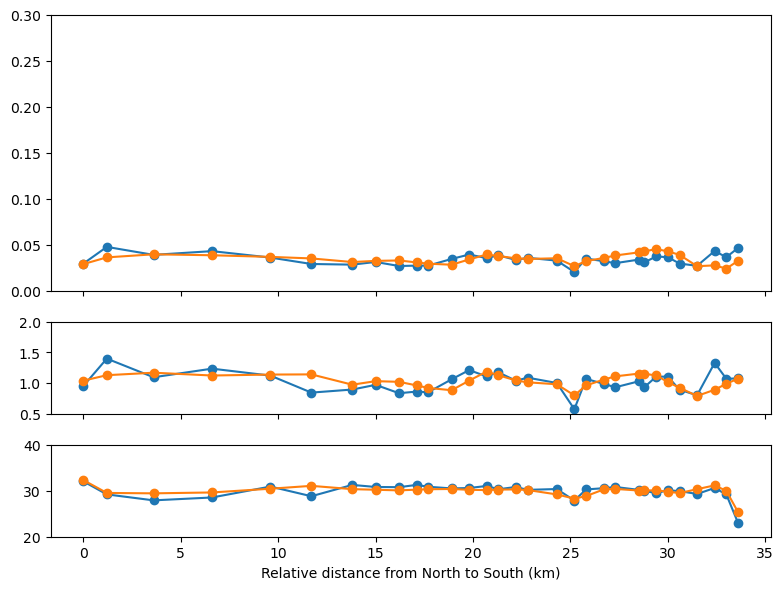

In [61]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]* 300 / 1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    ax4[n].plot(fwyp, (y_exact[n, tp, :]), label='observed', marker='o')
    ax4[n].plot(fwyp, (y_pred[tp-68, :, n]), label='predicted', marker='o')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
#     ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

#     lastpoint=-100
#     if n==0:
#         for p in range(len(xi)):
#             if (fwyp[p] - lastpoint) > 1.:
#                 ax4[n].text(fwyp[p], (y_pred[n, :, tp-68])[p] + 0.02, "none", rotation=90, fontsize=8)
#                 lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)